# Walkthrough - Hindsight Experience Replay (HER)

In this notebook, we provide a walkthrough of our implementation of Hindsight Experience Replay (HER) based on [arxiv.org/abs/1707.01495](https://arxiv.org/abs/1707.01495). We start by demonstrating the multi-goal DQN+HER implementation for the simple Bit-Flip environment that has been used by the author as a proof-of-concept to show that it work significantly better than DQN without HER.

The demonstration includes both training and comparision of the two methods.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
sys.path.append('src')

from environment import BitFlipEnv
from network import DQN
from replay_buffer import ReplayBuffer
from her_buffer import HERBuffer
from dqn_agent import DQNAgent
from dqn_her_agent import DQNHERAgent
from utils import print_training_progress, evaluate_agent

### The Bit-Flip environment

The Bit-Flip environment is a very simple multi-goal environment which randomly initialises a random n-bit binary number and sets it as the goal for the epsiode. The initial state is another random n-bit binary number and the agent's task is to flip the bits at each step to change the initial binary number to the goal binary number.

This environment has the following properties:

- $ \mathcal{S} = \{0,1\}^n $
- $ \mathcal{G} = \{0,1\}^n $
- $ \mathcal{A} = \{0, 1, ..., n-1\} $
- The policy has a rewards $-1$ everywhere except when the the environment state matches with the goal state.
- The length of each episode is equal to the number of bits, and the episode is successful if the goal state is achieved at an arbitrary timestep during the episode.

In [2]:
# Number of bits for the BitFlip environment
env = BitFlipEnv(n_bits=10)
obs_dict = env.reset()

In [3]:
print("Achieved State:")
print(obs_dict['achieved_goal'].astype(int))
print("Desired Goal - picked at random:")
print(obs_dict['desired_goal'].astype(int))

Achieved State:
[0 1 0 0 1 1 1 0 0 0]
Desired Goal - picked at random:
[0 1 0 0 1 0 0 1 1 0]


Taking a set of random actions:

In [4]:
actions = np.random.randint(0, env.n_bits, size=10)

print("Start state:", obs_dict['achieved_goal'].astype(int))
print()
for action in actions:
    obs_dict, reward, terminated, truncated, info = env.step(action)
    print(f"Action: Flip index {action}", end='; ')
    print("State:", obs_dict['achieved_goal'].astype(int), end='; ')
    print("Reward:", reward, end='; ')
    print(f"{terminated=}, {truncated=}")
    

Start state: [0 1 0 0 1 1 1 0 0 0]

Action: Flip index 6; State: [0 1 0 0 1 1 0 0 0 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 3; State: [0 1 0 1 1 1 0 0 0 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 2; State: [0 1 1 1 1 1 0 0 0 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 2; State: [0 1 0 1 1 1 0 0 0 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 8; State: [0 1 0 1 1 1 0 0 1 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 6; State: [0 1 0 1 1 1 1 0 1 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 6; State: [0 1 0 1 1 1 0 0 1 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 6; State: [0 1 0 1 1 1 1 0 1 0]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 9; State: [0 1 0 1 1 1 1 0 1 1]; Reward: -1.0; terminated=False, truncated=False
Action: Flip index 6; State: [0 1 0 1 1 1 0 0 1 1]; Reward: -1.0

### Creating the DQN Networks

DQN generally uses two identical networks, where one predicts Q-values for all possible actions, and another acts as the target network. The input dimensions is same as the dimensions of the observed state of the environment and the output dimensions is the number of possible actions.

However, in the multi-goal case utilised in HER, the input of Q-function also includes the goal state that is sampled from some distribution at the start of the episode. In our case we randomly sample the goal state. This is termed as _Universal Value Function Approxiamtors (UVFA)_, where the reward function, the policy, and the value functions also depend on the goal state and is widely used for multi-goal RL algorithms.

Thus, for every goal $g \in \mathcal{G}$ with some _goal space_ $\mathcal{G}$, there is some reward function $r_g: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$. The policy becomes $\pi : \mathcal{S} \times \mathcal{G} \rightarrow \mathcal{A}$, and the Q-function is now $Q^\pi(s_t, a_t, g) = \mathbb{E}[R_t | s_t, a_t, g]$.

In [5]:
# Input is now state and goal concatenated
q_network = DQN(
    input_size=2*env.n_bits,
    output_size=env.n_bits,
    hidden_sizes=[256]
)

target_q_network = DQN(
    input_size=2*env.n_bits,
    output_size=env.n_bits,
    hidden_sizes=[256]
)

her_q_network = DQN(
    input_size=2*env.n_bits,
    output_size=env.n_bits,
    hidden_sizes=[256]
)

target_her_q_network = DQN(
    input_size=2*env.n_bits,
    output_size=env.n_bits,
    hidden_sizes=[256]
)

# Replicating initialised weights from q_network to target_q_network
target_q_network.load_state_dict(q_network.state_dict())
target_her_q_network.load_state_dict(her_q_network.state_dict())

# Gradients for target network ar never calculated
target_q_network.eval()
target_her_q_network.eval()

# Initializing optimizers
lr = 0.001
optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)
her_optimizer = torch.optim.Adam(her_q_network.parameters(), lr=lr)

### The Replay Buffers

This is where Hindsight Experience Replay introduces its most influential modification. For every episode added to the replay buffer, HER proposes to add the same epsiode again with the goal modified and the rewards updated accordingly. This adds a significant number of transitions that achieve some goal successfully, thus increasing the proportion of successful episodes, which wouldn't have been possible for random exploration in a sparse environment.

The principal variations lie in for every added episode, how is the goal modified. Any of the state in the episode could be taken as the new goal. Or for every timestep, we could take any of the later states as the goal and add the transition with the new goal to the buffer. We could also decide how many new goals should be chosen corresponding to which transitions are added to the buffer. This number controls the proportion of actual transitions and the modified transitions in the buffer.

In the current demonstration, we use what the author call the _future_ strategy of choosing goals, in which for every timestep in an episode, later states are chosen as goals randomly and the transition is added to the buffer. And for every timestamp, sampling and adding 4 such goals was shown to be the best strategy.

In [6]:
buffer_size = 100_000
replay_buffer = ReplayBuffer(
    capacity=buffer_size,
    observation_size=2*env.n_bits
)
her_replay_buffer = HERBuffer(
    capacity=buffer_size, 
    observation_size=2*env.n_bits, 
    goal_size=env.n_bits,
    her_strategy="future",
    her_k=4
)

### Training DQN and DQN+HER

Most of the training steps are same for both the agents except for some superficial changes to storing results and passing paramteres.

Here, we will use `DQNAgent` and `DQNHERAgent` that have some helpful functions for training and evaluation.

Here, we have divided the training into 50 epochs with each epoch containing 50 episodes. This helps us to visualise the success rate in every epoch. The target network weights are updated after every 100 iterations. We use the Adam optimiser with 0.001 learning rate.

In [7]:
dqn_agent = DQNAgent(
    observation_size=env.n_bits*2,
    action_size=env.n_bits,
)
dqn_agent.policy_net = q_network
dqn_agent.target_net = target_q_network
dqn_agent.optimizer = optimizer
dqn_agent.replay_buffer = replay_buffer

her_dqn_agent = DQNHERAgent(
    observation_size=env.n_bits*2,
    action_size=env.n_bits,
    goal_size=env.n_bits,
)
her_dqn_agent.policy_net = her_q_network
her_dqn_agent.target_net = target_her_q_network
her_dqn_agent.optimizer = her_optimizer
her_dqn_agent.replay_buffer = her_replay_buffer

In [8]:
def train(agent, env, her=False, num_epochs=200, 
          episodes_per_epoch=50, verbose=False):
    env.reset()

    # Training metrics
    epoch_rewards = []
    epoch_success_rates = []
    epoch_losses = []
    epoch_q_values = []
    all_episode_rewards = []
    all_episode_successes = []

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", disable=verbose):
        epoch_total_reward = 0
        epoch_successes = []
        epoch_loss_values = []
        epoch_q_value_list = []

        for episode in tqdm(range(episodes_per_epoch), desc=f"Epoch {epoch}/{num_epochs}", disable=(not verbose)):
            obs_dict = env.reset()
            observation = obs_dict['observation']

            achieved_goal = None
            desired_goal = None
            if her:
                achieved_goal = obs_dict['achieved_goal']
                desired_goal = obs_dict['desired_goal']
            
            episode_reward = 0
            done = False
            steps = 0
            
            while not done and steps < env.max_steps:
                # Select action
                action = agent.select_action(observation, training=True)
                
                # Take step
                next_obs_dict, reward, terminated, truncated, info = env.step(action)
                next_observation = next_obs_dict['observation']
                next_achieved_goal = None
                if her:
                    next_achieved_goal = next_obs_dict['achieved_goal']
                done = terminated or truncated
                
                # Store transition
                if her:
                    agent.store_transition(
                        observation, action, reward, next_observation, done,
                        achieved_goal, desired_goal, next_achieved_goal
                    )
                else:
                    agent.store_transition(observation, action, reward, next_observation, done)
                
                # Update agent
                metrics = agent.update()
                if metrics:
                    epoch_loss_values.append(metrics['loss'])
                    epoch_q_value_list.append(metrics['q_value'])
                
                observation = next_observation

                if her:
                    achieved_goal = next_achieved_goal
                episode_reward += reward
                steps += 1
            
            # In case of HER, triggers HER replays
            agent.end_episode()
            epoch_total_reward += episode_reward
            epoch_successes.append(info['is_success'])
            all_episode_rewards.append(episode_reward)
            all_episode_successes.append(info['is_success'])
        
        # Epoch statistics
        mean_reward = epoch_total_reward / episodes_per_epoch
        success_rate = np.mean(epoch_successes)
        mean_loss = np.mean(epoch_loss_values) if epoch_loss_values else 0.0
        mean_q_value = np.mean(epoch_q_value_list) if epoch_q_value_list else 0.0
        
        epoch_rewards.append(mean_reward)
        epoch_success_rates.append(success_rate)
        epoch_losses.append(mean_loss)
        epoch_q_values.append(mean_q_value)

        # Print progress
        if epoch % 1 == 0:
            if verbose:
                print_training_progress(epoch, num_epochs, {
                    'Mean Reward': mean_reward,
                    'Success Rate': success_rate,
                    'Loss': mean_loss,
                    'Q-value': mean_q_value,
                    'Epsilon': agent.epsilon,
                    'Buffer Size': len(agent.replay_buffer)
                })
    
    # Final evaluation
    eval_metrics = evaluate_agent(agent, env, num_episodes=100)

    if verbose:
        print("\nFinal Evaluation...")
    print(f"Final Success Rate: {eval_metrics['success_rate']:.4f}")
    print(f"Mean Episode Length: {eval_metrics['mean_episode_length']:.2f}")

    # Save results
    results = {
        'epoch_rewards': epoch_rewards,
        'epoch_success_rates': epoch_success_rates,
        'epoch_losses': epoch_losses,
        'epoch_q_values': epoch_q_values,
        'all_episode_rewards': all_episode_rewards,
        'all_episode_successes': all_episode_successes,
        'final_eval': eval_metrics,
        'total_episodes': num_epochs * episodes_per_epoch
    }
    if her:
        results['algorithm'] = 'DQN-HER'
    else:
        results['algorithm'] = 'DQN'

    if verbose:
        print("\nTraining completed!")
    
    return results

In [9]:
dqn_results = train(dqn_agent, env, her=False, num_epochs=30, episodes_per_epoch=16)

Training Progress: 100%|██████████| 30/30 [00:07<00:00,  4.04it/s]

Final Success Rate: 0.0100
Mean Episode Length: 9.92


In [10]:
her_dqn_results = train(her_dqn_agent, env, her=True, num_epochs=30, episodes_per_epoch=16)

Training Progress: 100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


Final Success Rate: 1.0000
Mean Episode Length: 5.02


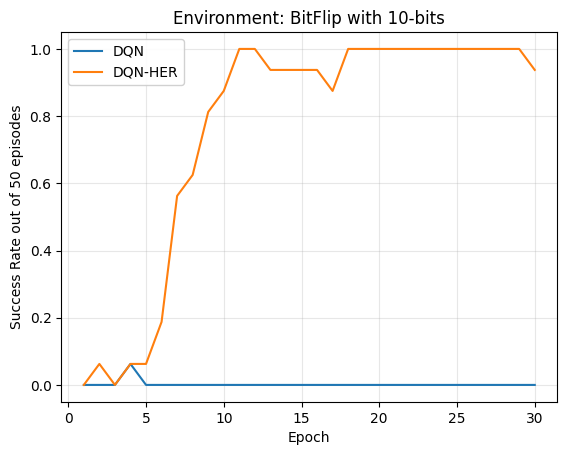

In [11]:
results_to_plot = {
    'DQN': dqn_results,
    'DQN-HER': her_dqn_results
}

plt.figure()

for name, result_data in results_to_plot.items():
    success_rates = result_data['epoch_success_rates']
    epochs = np.arange(1, len(success_rates) + 1)
    
    plt.plot(epochs, success_rates, label=name)

plt.xlabel('Epoch')
plt.ylabel('Success Rate out of 50 episodes')
plt.title(f'Environment: BitFlip with {env.n_bits}-bits')
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.show()

### Comparing DQN and DQN-HER

Now, with this minimal implementation, we could demonstrate that above a certain number of bits, DQN fails to achieve any consistent success. Whereas DQN with HER achieves almost perfect success rate. This is the result of the reward getting more sparse as the search space becomes larger with only one state having non-negative reward.

In [13]:
def get_networks_and_optimizers(env):
    q_network = DQN(
        input_size=2*env.n_bits,
        output_size=env.n_bits,
        hidden_sizes=[256]
    )

    target_q_network = DQN(
        input_size=2*env.n_bits,
        output_size=env.n_bits,
        hidden_sizes=[256]
    )

    # Replicating initialised weights from q_network to target_q_network
    target_q_network.load_state_dict(q_network.state_dict())

    # Gradients for target network ar never calculated
    target_q_network.eval()

    # Initializing optimizers
    lr = 0.001
    optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)

    return (q_network, target_q_network, optimizer)

def multiple_train(bits=[5], her=True, num_epochs=30, episodes_per_epoch=16):
    n_bits_list = []
    eval_success_rates = []
    for n_bits in bits:
        print(f"\nNumber of bits: {n_bits}")
        env = BitFlipEnv(n_bits=n_bits)

        q_network, target_q_network, optimizer = get_networks_and_optimizers(env)

        buffer_size = 100_000
        agent = None
        replay_buffer = None
        if not her:
            agent = DQNAgent(
                observation_size=env.n_bits*2,
                action_size=env.n_bits,
                epsilon_end=0.2
            )
            replay_buffer = ReplayBuffer(
                capacity=buffer_size,
                observation_size=2*env.n_bits
            )
        else:
            agent = DQNHERAgent(
                observation_size=env.n_bits*2,
                action_size=env.n_bits,
                goal_size=env.n_bits,
                epsilon_end=0.2
            )
            replay_buffer = HERBuffer(
                capacity=buffer_size, 
                observation_size=2*env.n_bits, 
                goal_size=env.n_bits,
                her_strategy="future",
                her_k=4
            )
        
        buffer_size = 100_000

        agent.policy_net = q_network
        agent.target_net = target_q_network
        agent.optimizer = optimizer
        dqn_agent.replay_buffer = replay_buffer
        
        results = train(agent, env, her=her, num_epochs=num_epochs, episodes_per_epoch=episodes_per_epoch)
        
        n_bits_list.append(n_bits)
        eval_success_rates.append(results['final_eval']['success_rate'])
    
    return n_bits_list, eval_success_rates

In [17]:
results =  multiple_train(bits=[5,10,15,20,25,30], her=False, num_epochs=100, episodes_per_epoch=50)


Number of bits: 5


Training Progress: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Final Success Rate: 1.0000
Mean Episode Length: 2.69

Number of bits: 10


Training Progress: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Final Success Rate: 0.0000
Mean Episode Length: 10.00

Number of bits: 15


Training Progress: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Final Success Rate: 0.0000
Mean Episode Length: 15.00

Number of bits: 20


Training Progress: 100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


Final Success Rate: 0.0000
Mean Episode Length: 20.00

Number of bits: 25


Training Progress: 100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


Final Success Rate: 0.0000
Mean Episode Length: 25.00

Number of bits: 30


Training Progress: 100%|██████████| 100/100 [05:31<00:00,  3.31s/it]


Final Success Rate: 0.0000
Mean Episode Length: 30.00


In [18]:
her_results = multiple_train(bits=[5,10,15,20,25,30], her=True, num_epochs=100, episodes_per_epoch=50)


Number of bits: 5


Training Progress: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


Final Success Rate: 1.0000
Mean Episode Length: 2.64

Number of bits: 10


Training Progress: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Final Success Rate: 1.0000
Mean Episode Length: 4.92

Number of bits: 15


Training Progress: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Final Success Rate: 1.0000
Mean Episode Length: 7.40

Number of bits: 20


Training Progress: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Final Success Rate: 1.0000
Mean Episode Length: 9.90

Number of bits: 25


Training Progress: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


Final Success Rate: 1.0000
Mean Episode Length: 12.37

Number of bits: 30


Training Progress: 100%|██████████| 100/100 [05:08<00:00,  3.09s/it]


Final Success Rate: 0.4400
Mean Episode Length: 22.81


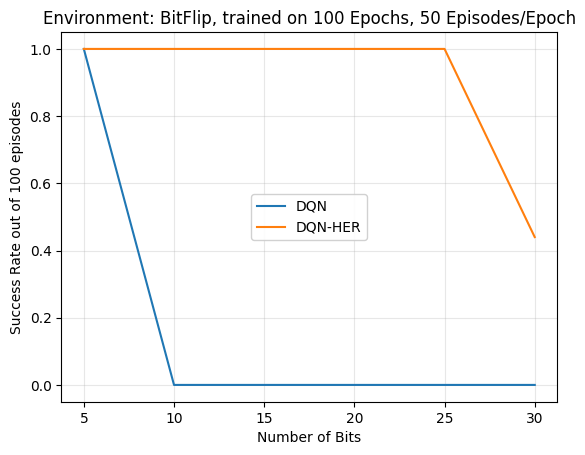

In [19]:
plt.figure()

plt.plot(results[0], results[1], label='DQN')
plt.plot(her_results[0], her_results[1], label='DQN-HER')

plt.xlabel('Number of Bits')
plt.ylabel('Success Rate out of 100 episodes')
plt.title('Environment: BitFlip, trained on 100 Epochs, 50 Episodes/Epoch')
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.show()